In [1]:
import os
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
sys.path.append('../python/')

from plotMethods import *
from UNetMethods import *
from constants import *

In [3]:
sys.path.append('../pytorch-3dunet/')

from pytorch3dunet.predict import main

In [ ]:
modelPath = '/Users/noah-everett/Documents/Research/DSPS-Detector/analysis/models/UNet_v6_0/checkpoints/last_checkpoint.pytorch'

# data_numbers = np.arange(200, 221)
data_numbers = np.array([217])
data_dir = '/Volumes/SD/DSPS/fasrc/trainData_6/'
data_paths = [data_dir + i + '.h5' for i in data_numbers.astype(str)]
data_paths = [p for p in data_paths if os.path.exists(p)]
print("Data paths:", data_paths)

outputDir = '/Users/noah-everett/Documents_non-iCloud/modelOut_v6_best/'

Data paths: ['/Volumes/SD/DSPS/fasrc/trainData_6/217.h5']


In [5]:
config = get_config_predict(data_paths, modelPath, outputDir)
save_config(config, outputDir+'/config.yml')

In [6]:
main(['--config', outputDir+'/config.yml'])

2025-08-12 17:15:03,948 [MainThread] WARNING ConfigLoader - CPU mode forced in config, this will likely result in slow training/prediction
2025-08-12 17:15:03,962 [MainThread] INFO UNet3DPredict - Loading model from /Users/noah-everett/Documents/Research/DSPS-Detector/analysis/models/UNet_v6/checkpoints/last_checkpoint.pytorch...
2025-08-12 17:15:04,459 [MainThread] INFO Dataset - Creating test set loaders...
2025-08-12 17:15:04,459 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2025-08-12 17:15:04,460 [MainThread] INFO HDF5Dataset - Loading test set from: /Volumes/SD/DSPS/fasrc/trainData_6/217.h5...
2025-08-12 17:15:04,461 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 80, 80], 'skip_shape_check': True, 'stride_shape': [40, 40, 40]}
2025-08-12 17:15:04,471 [MainThread] INFO HDF5Dataset - Number of patches: 1
2025-08-12 17:15:04,471 [MainThread] INFO Dataset - Number of workers

100%|██████████| 1/1 [00:03<00:00,  3.71s/it]

2025-08-12 17:15:08,199 [MainThread] INFO UNetPredictor - Finished inference in 3.73 seconds
2025-08-12 17:15:08,201 [MainThread] INFO UNetPredictor - Saving probability maps to: /Users/noah-everett/Documents_non-iCloud/modelOut_v6_last/217_predictions.h5


In [7]:
fileNumber = 217 #56 #45 #30

# file = f'/Users/noah-everett/Documents_non-iCloud/modelOut_v2/{fileNumber}_predictions.h5'
file = f'{outputDir}/{fileNumber}_predictions.h5'
f = h5py.File(file, 'r')
pred = f['predictions'][:]
f.close()
pred = pred[0,:,:,:]

# file = f'/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdataNumbers/{fileNumber}.h5'
file = f'{data_dir}/{fileNumber}.h5'
f = h5py.File(file, 'r')
true = f['y'][:]
f.close()
true = true[:,:,:]

N = 40
step = (pred.shape[0]//N, pred.shape[1]//N, pred.shape[2]//N)
assert (pred.shape[0] % N == 0) and (pred.shape[1] % N == 0) and (pred.shape[2] % N == 0)
pred = pred.reshape(N, step[0], N, step[1], N, step[2]).mean(axis=(1,3,5))
true = true.reshape(N, step[0], N, step[1], N, step[2]).mean(axis=(1,3,5))

np.min(pred): 0.00043665772
np.max(pred): 0.99872875
minVal (top N): 0.65837777
maxVal (top N): 0.99872875


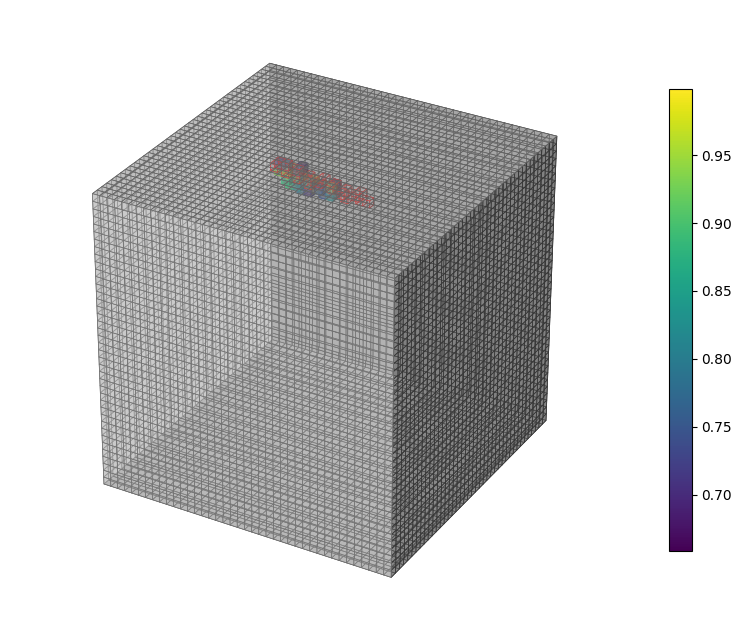

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

gridSize = pred.shape

xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2, DETECTOR_SIZE_MM[0]/2, gridSize[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2, DETECTOR_SIZE_MM[1]/2, gridSize[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2, DETECTOR_SIZE_MM[2]/2, gridSize[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

print('np.min(pred):', np.min(pred))
print('np.max(pred):', np.max(pred))

### Use percentile to find shown voxels
# minPercentile = 99.5
# maxPercentile = 100
# minVal = np.percentile(pred, minPercentile)
# maxVal = np.percentile(pred, maxPercentile)
# print(f'minVal ({minPercentile}th percentile):', minVal)
# print(f'maxVal ({maxPercentile}th percentile):', maxVal)

### Show top N voxels
N = 30
topNIndices = np.unravel_index(np.argsort(pred.ravel())[-N:], pred.shape)
minVal = pred[topNIndices].min()
maxVal = pred[topNIndices].max()
print('minVal (top N):', minVal)
print('maxVal (top N):', maxVal)

alpha_filled = 0.5
globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)
pred = np.where(pred < minVal, 0, pred)
colors = cm.viridis(globalColorNorm(pred))

ax = plot_grid(
    ax,
    xEdges,
    yEdges,
    zEdges,
    recoGrid=pred,
    recoGridFaceColors=colors,
    recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
    recoGridAlpha=alpha_filled,
    trueGrid=true,
    trueGridEdgeColors='red',
    trueGridAlpha=0,
    linewidth=0.5,
    cbar=True,
    colorNorm=globalColorNorm,
    cmap=cm.viridis,
)

ax.set_axis_off()
ax.set_aspect('equal')

plt.show()

In [17]:
# File numbers to plot
fileNumbers = range(200, 220)
# fileNumbers = range(0, 200)
# fileNames_recos = [f'/Users/noah-everett/Documents_non-iCloud/modelOut_v2/{i}_predictions.h5' for i in fileNumbers]
fileNames_recos = [f'{outputDir}/{i}_predictions.h5' for i in fileNumbers]
# fileNames_trues = [f'/Users/noah-everett/Documents_non-iCloud/DSPS/tmp/MLdataNumbers/{i}.h5' for i in fileNumbers]
fileNames_trues = [f'{data_dir}/{i}.h5' for i in fileNumbers]

# Load data
data_recos = [h5py.File(i, 'r')['predictions'][0,:,:,:] for i in tqdm(fileNames_recos)]
data_trues = [h5py.File(i, 'r')['y'][:,:,:] for i in tqdm(fileNames_trues)]
assert len(data_recos) == len(data_trues)
assert all([i.shape == j.shape for i, j in zip(data_recos, data_trues)])
assert all(data_recos[0].shape == i.shape for i in data_recos)

# Resize the data
M = 20
step = (data_recos[0].shape[0]//M, data_recos[0].shape[1]//M, data_recos[0].shape[2]//M)
assert (data_recos[0].shape[0] % M == 0) and (data_recos[0].shape[1] % M == 0) and (data_recos[0].shape[2] % M == 0)
data_recos = [i.reshape(M, step[0], M, step[1], M, step[2]).mean(axis=(1,3,5)) for i in data_recos]
data_trues = [i.reshape(M, step[0], M, step[1], M, step[2]).mean(axis=(1,3,5)) for i in data_trues]

# Data for plotting
scale = 1000 # mm -> m
xEdges = np.linspace(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale, data_recos[0].shape[0] + 1)
yEdges = np.linspace(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale, data_recos[0].shape[1] + 1)
zEdges = np.linspace(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale, data_recos[0].shape[2] + 1)
yEdges, xEdges, zEdges = np.meshgrid(xEdges, yEdges, zEdges)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

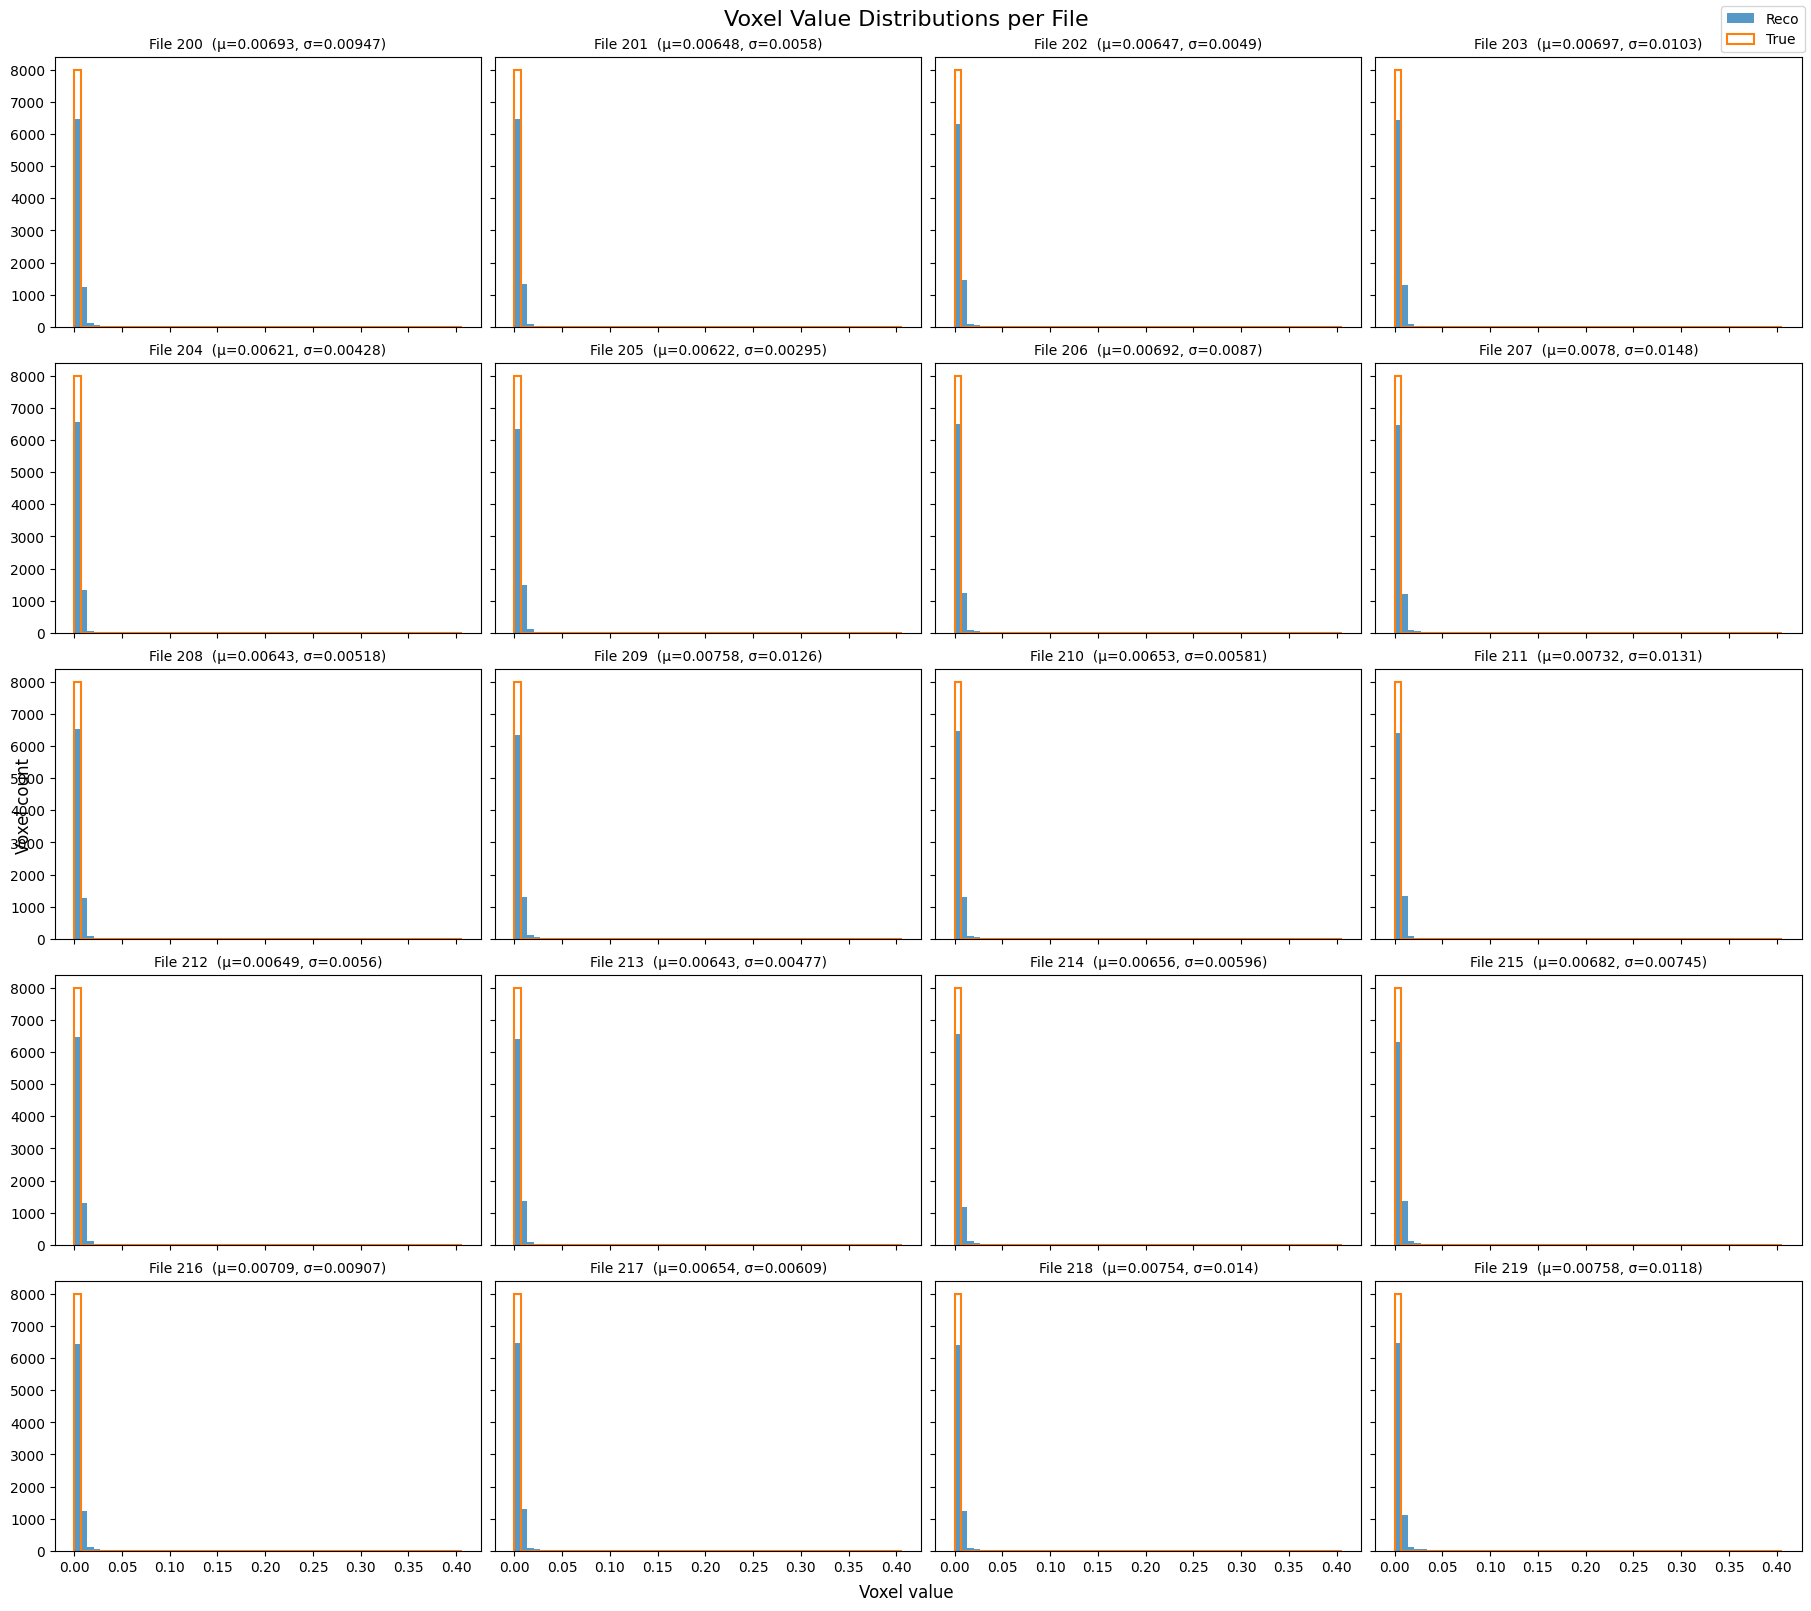

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Choose which data to plot ---
# Set this to True if you want to overlay the ground-truth hist in each panel.
overlay_true = True  # False -> only predictions (recos)

# --- Flatten per-file volumes ---
recos_flat = [arr.ravel() for arr in data_recos]
trues_flat = [arr.ravel() for arr in data_trues] if overlay_true else None

# --- Compute common bin edges for comparability (robust to outliers) ---
# Use percentiles across ALL files so axes/bins are consistent.
all_for_range = np.concatenate(recos_flat + (trues_flat if overlay_true else []))
lo, hi = np.nanpercentile(all_for_range, [0, 100])  # clip extremes; adjust if needed
bins = 60  # adjust as you like
bin_edges = np.linspace(lo, hi, bins + 1)

# --- Layout ---
n = len(fileNumbers)  # should be 20
rows, cols = 5, 4     # or swap to (4,5) if you prefer
assert rows * cols >= n

fig, axes = plt.subplots(rows, cols, figsize=(18, 16), sharex=True, sharey=True, constrained_layout=True)
axes = np.asarray(axes).reshape(rows, cols)

# --- Plot ---
for k, (ax, fname_idx) in enumerate(zip(axes.flat, range(n))):
    vals_reco = recos_flat[fname_idx]
    ax.hist(vals_reco, bins=bin_edges, alpha=0.75, label='Reco', histtype='stepfilled')

    if overlay_true:
        vals_true = trues_flat[fname_idx]
        ax.hist(vals_true, bins=bin_edges, histtype='step', linewidth=1.5, label='True')

    # Stats for the panel title
    mu = np.nanmean(vals_reco)
    sd = np.nanstd(vals_reco)
    file_id = fileNumbers[fname_idx]
    ax.set_title(f"File {file_id}  (μ={mu:.3g}, σ={sd:.3g})", fontsize=10)

    # Optional: log scale if there’s a big dynamic range in counts
    # ax.set_yscale('log')

# Hide any unused axes (in case rows*cols > n)
for ax in axes.flat[n:]:
    ax.axis('off')

# Labels and legend
fig.supylabel("Voxel count", x=0.005)
fig.supxlabel("Voxel value")
handles, labels = axes[0,0].get_legend_handles_labels()
if overlay_true:
    # One shared legend
    fig.legend(handles, labels, loc="upper right")

fig.suptitle("Voxel Value Distributions per File", fontsize=16)
plt.show()

# Optionally save
# fig.savefig("voxel_hist_grid.png", dpi=200, bbox_inches="tight")


In [19]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def prepare_data(data_trues, data_preds, binarize=True, threshold=0.5):
    true_concat = np.concatenate([arr.flatten() for arr in data_trues])
    preds_concat = np.concatenate([arr.flatten() for arr in data_preds])
    if binarize:
        true_concat = (true_concat >= threshold).astype(int)
    return true_concat, preds_concat

def loss_function(params, true, preds):
    valMin, valMax = params
    if valMin >= valMax:
        return np.inf
    mask = ((preds > valMin) & (preds < valMax)).astype(int)
    loss = np.sum(mask != true)
    return loss

def find_optimal_thresholds(true, preds):
    initial_guess = [0.0, 0.1]
    bounds = [(0.0, 1.0), (0.0, 1.0)]
    constraints = ({
        'type': 'ineq',
        'fun': lambda x: x[1] - x[0] - 1e-5
    })
    result = minimize(
        loss_function, 
        initial_guess, 
        args=(true, preds),
        method='L-BFGS-B',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        valMin_opt, valMax_opt = result.x
        print(f"Optimal valMin: {valMin_opt:.4f}, valMax: {valMax_opt:.4f}")
        return valMin_opt, valMax_opt
    else:
        raise ValueError("Optimization failed. Please check your data or try different initial parameters.")

def evaluate_thresholds(true, preds, valMin, valMax):
    mask = ((preds > valMin) & (preds < valMax)).astype(int)
    accuracy = accuracy_score(true, mask)
    precision = precision_score(true, mask, zero_division=0)
    recall = recall_score(true, mask, zero_division=0)
    f1 = f1_score(true, mask, zero_division=0)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

true_flat, preds_flat = prepare_data(data_trues, data_recos, binarize=True, threshold=0.01)
unique_labels_after_binarization = np.unique(true_flat)
print(f"Unique labels after binarization: {unique_labels_after_binarization}")
if not np.array_equal(unique_labels_after_binarization, [0, 1]):
    raise ValueError(f"Post-binarization, true labels must be binary (0 and 1). Found unique labels: {unique_labels_after_binarization}")
valMin_opt, valMax_opt = find_optimal_thresholds(true_flat, preds_flat)
minVal = valMin_opt
maxVal = valMax_opt
evaluate_thresholds(true_flat, preds_flat, valMin_opt, valMax_opt)

Unique labels after binarization: [0 1]
Optimal valMin: 0.0000, valMax: 0.1000
Accuracy: 0.0032
Precision: 0.0016
Recall: 0.8581
F1 Score: 0.0032


/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8697/1707148268.py:27: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  result = minimize(


0it [00:00, ?it/s]

/var/folders/mv/_50rblmd16xfrbsjpr4x2z0c0000gn/T/ipykernel_8697/903786013.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


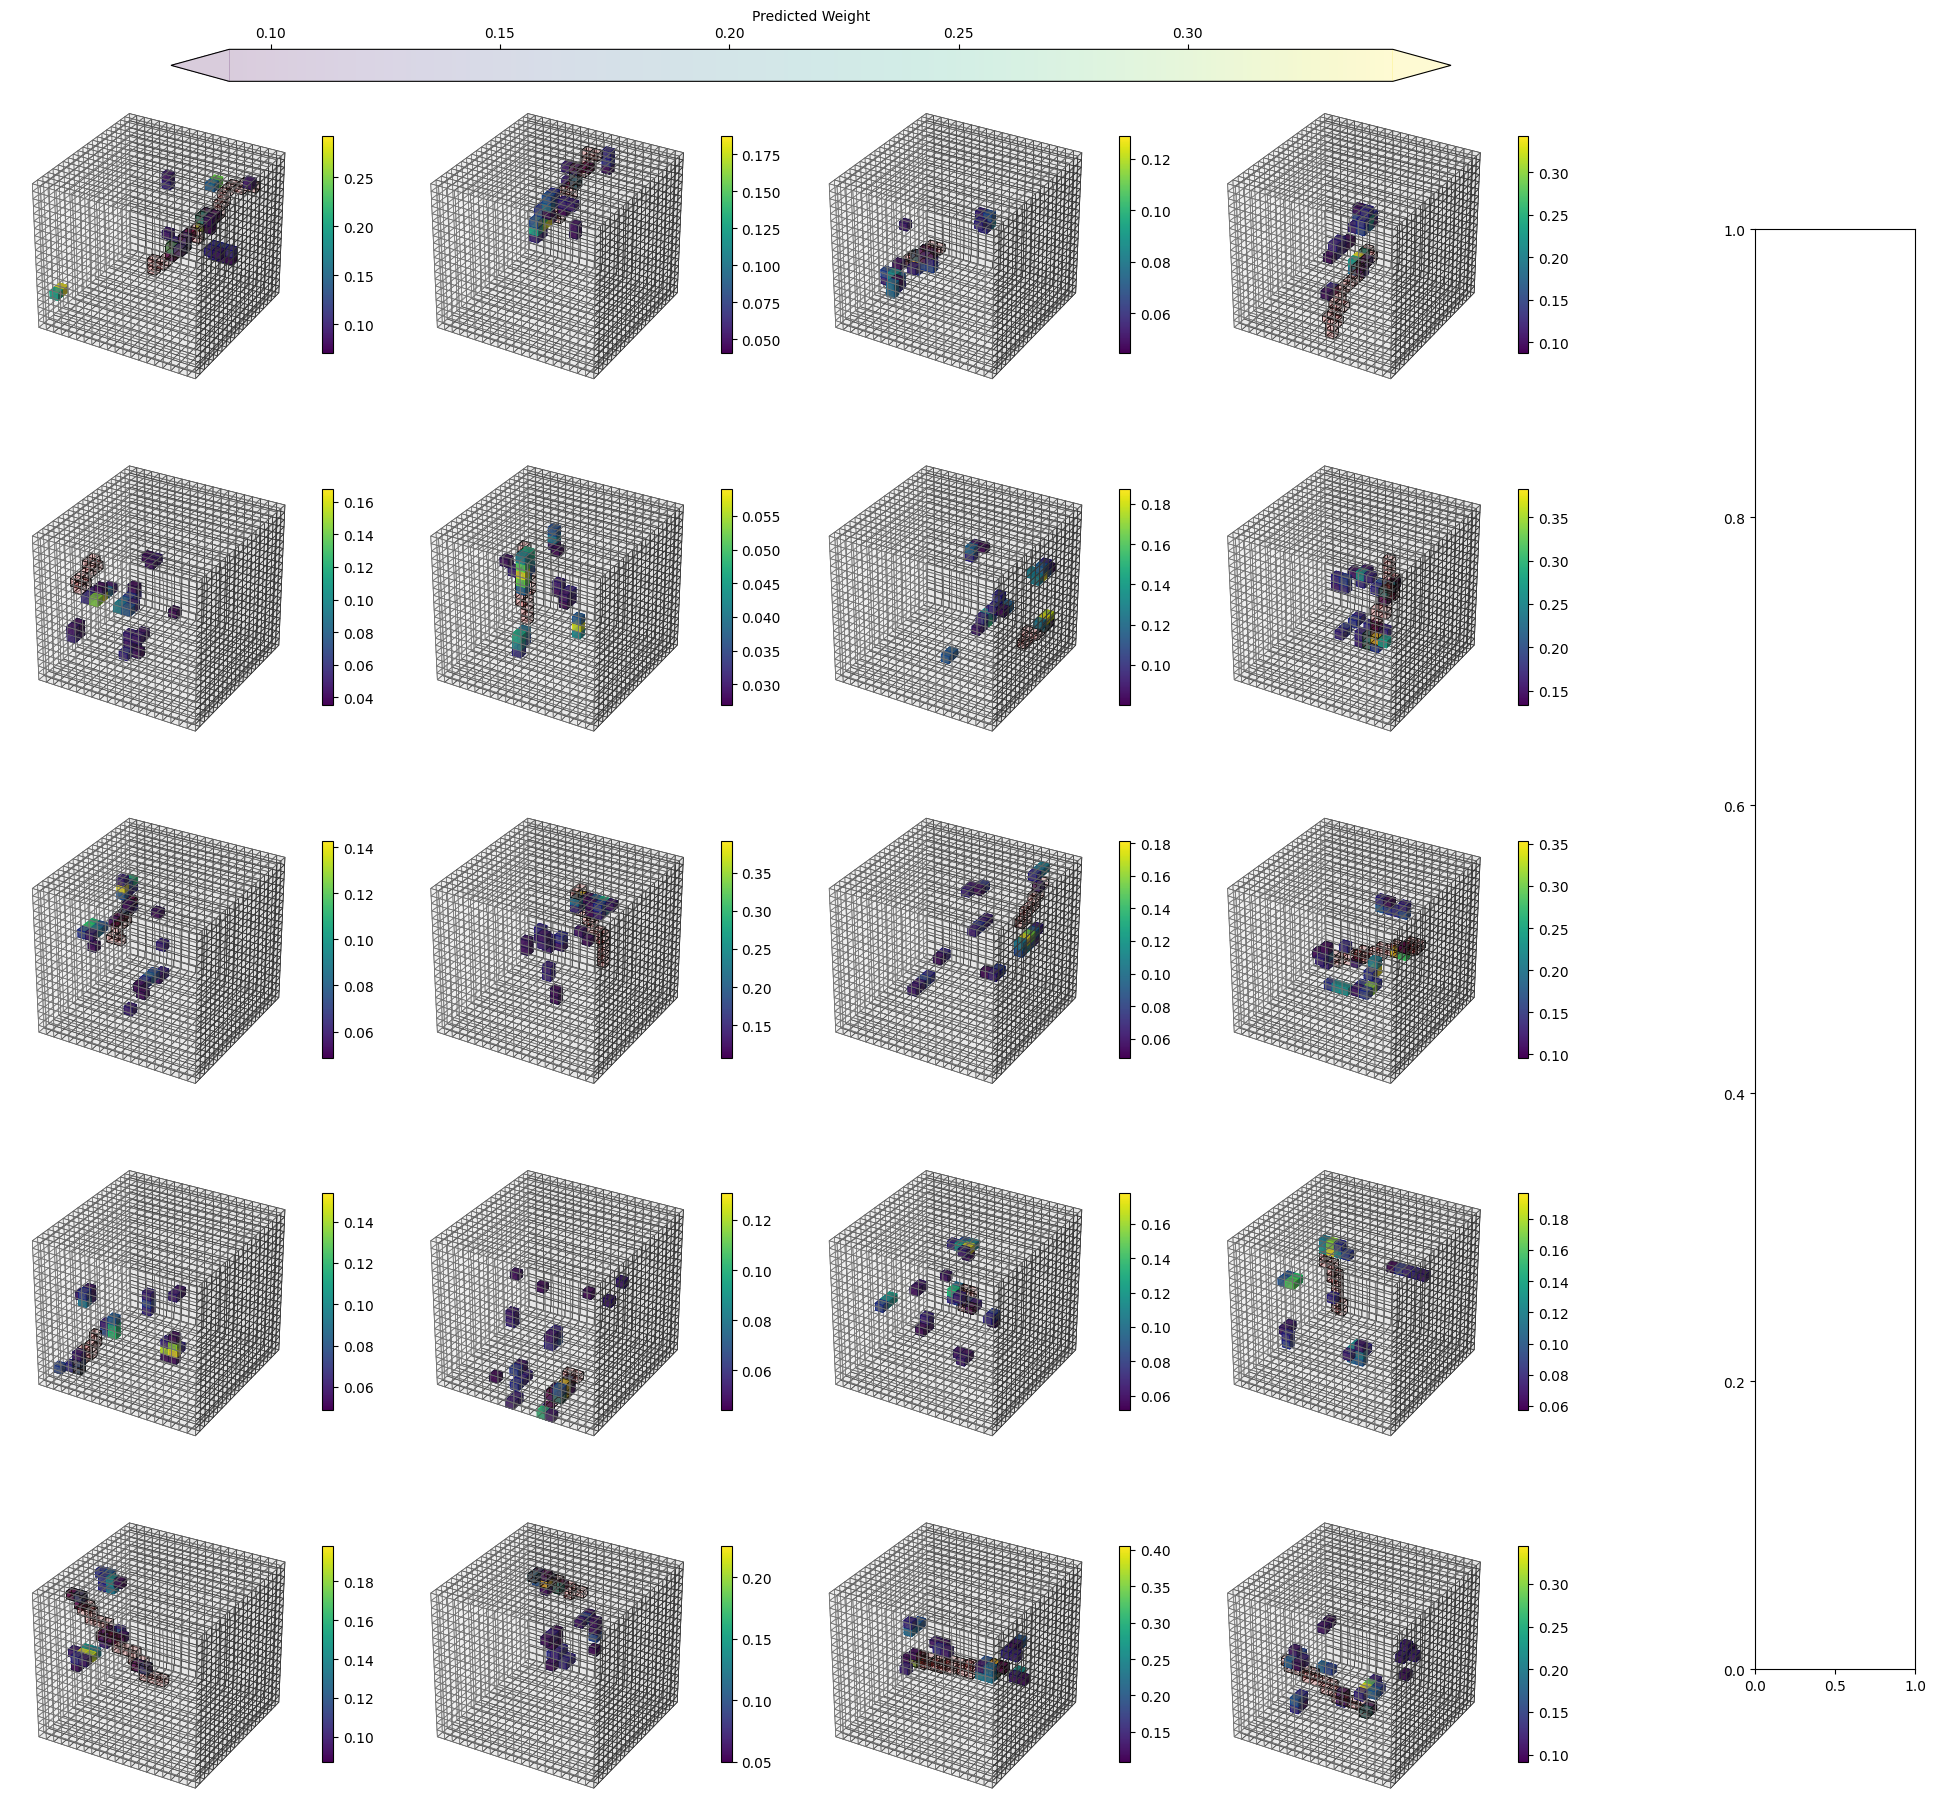

In [ ]:
# Meta plot settings
nCols = 4
nRows = 5
assert len(fileNumbers) == nCols*nRows
fig, axs = plt.subplots(nRows, nCols, figsize=(16, 18), subplot_kw={'projection': '3d'})

globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)

for ind, (predGrid, trueGrid) in tqdm(enumerate(zip(data_recos, data_trues))):
    # Find top N voxels
    N = 30
    topNIndices = np.unravel_index(np.argsort(predGrid.ravel())[-N:], predGrid.shape)
    minVal = predGrid[topNIndices].min()
    maxVal = predGrid[topNIndices].max()
    predGrid = np.where(predGrid < minVal, 0, predGrid)
    globalColorNorm = cm.colors.Normalize(vmin=minVal, vmax=maxVal)

    colors = cm.viridis(globalColorNorm(predGrid))

    axs[ind//nCols, ind%nCols] = plot_grid(
        axs[ind//nCols, ind%nCols],
        xEdges,
        yEdges,
        zEdges,
        recoGrid=predGrid,
        recoGridFaceColors=colors,
        recoGridEdgeColors=np.clip(colors*2-0.5, 0, 1),
        recoGridAlpha=0.8,
        trueGrid=trueGrid,
        trueGridFaceColors='r',
        trueGridEdgeColors='k',
        trueGridAlpha=0.1,
        nullGridAlpha=0.1,
        linewidth=0.5,
        # truePoints=primaryTrue/scale,
        # truePointsColor='r',
        # truePointsSize=30,
        # truePointsAlpha=0.1,
        # cbar=False,
        cbar=True,
        colorNorm=globalColorNorm,
        cmap=cm.viridis
    )

    axs[ind//nCols, ind%nCols].set_xlim(-DETECTOR_SIZE_MM[0]/2/scale, DETECTOR_SIZE_MM[0]/2/scale)
    axs[ind//nCols, ind%nCols].set_ylim(-DETECTOR_SIZE_MM[1]/2/scale, DETECTOR_SIZE_MM[1]/2/scale)
    axs[ind//nCols, ind%nCols].set_zlim(-DETECTOR_SIZE_MM[2]/2/scale, DETECTOR_SIZE_MM[2]/2/scale)

    axs[ind//nCols, ind%nCols].set_xlabel(r'$x$ [m]', labelpad=7)
    axs[ind//nCols, ind%nCols].set_ylabel(r'$y$ [m]')
    axs[ind//nCols, ind%nCols].set_zlabel(r'$z$ [m]', labelpad=0)

axNew = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axNew.set_visible(False)
cbar = plt.colorbar(cm.ScalarMappable(norm=globalColorNorm, cmap=cm.viridis), ax=axNew, orientation='horizontal', label='Predicted Weight', alpha=0.2, pad=0.1, aspect=40, shrink=0.8, extend='both')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_position([0.11, 0.1, 0.8, 0.9])

axExtend = fig.add_axes([1.1, 0.1, 0.1, 0.8])
axExtend.set_visible(True)

fig.tight_layout()
plt.savefig(f'{outputDir}/allTestEvents.pdf', bbox_inches='tight')
plt.show()